In [1]:
%load_ext autoreload

In [21]:
from sklearn.model_selection import KFold
import optuna
optuna.logging.set_verbosity(optuna.logging.INFO)

from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor, plot_importance
import pandas as pd
import numpy as np

In [3]:
%autoreload
from pipeline import Pipeline
pipin = Pipeline()

Current working directory: /Users/miksx/GitHub/Forest-Gump/mikael/optuna


In [4]:
df1_0 = pipin.get_data("A")
df2_0 = pipin.get_data("B")
df3_0 = pipin.get_data("C")

In [5]:
# remove_consecutive_measurments
# 6/24
# dette skal prøve å gjenskape henning sin
df1_0 = pipin.remove_consecutive_measurments_new(df1_0, 4, 12)
df2_0 = pipin.remove_consecutive_measurments_new(df2_0, 4, 12)
df3_0 = pipin.remove_consecutive_measurments_new(df3_0, 4, 12)

In [6]:
df1_0 = pipin.drop_columns(df1_0)
df2_0 = pipin.drop_columns(df2_0)
df3_0 = pipin.drop_columns(df3_0)
print(df1_0.shape, df2_0.shape, df3_0.shape)

(23905, 47) (16471, 47) (13750, 47)


In [7]:
df1_0.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,estimated,observed,day_of_year,hour,pv_measurement
0,7.700,1.22825,1728.949951,0.000000,0.00,1728.949951,0.0,280.299988,0.000,0.000000,...,0.0,286.225006,100.000000,40386.476562,3.600,0.0,1.0,153.0,22.0,0.00
1,7.700,1.22350,1689.824951,0.000000,0.00,1689.824951,0.0,280.299988,0.000,0.000000,...,0.0,286.899994,100.000000,33770.648438,3.350,0.0,1.0,153.0,23.0,0.00
2,7.875,1.21975,1563.224976,0.000000,0.00,1563.224976,0.0,280.649994,0.000,0.000000,...,0.0,286.950012,100.000000,13595.500000,3.050,0.0,1.0,154.0,0.0,0.00
3,8.425,1.21800,1283.425049,208.649994,0.75,1283.425049,0.0,281.674988,0.300,526.775024,...,0.0,286.750000,100.000000,2321.850098,2.725,0.0,1.0,154.0,1.0,0.00
4,8.950,1.21800,1003.500000,32468.150391,23.10,1003.500000,0.0,282.500000,11.975,22068.949219,...,0.0,286.450012,99.224998,11634.799805,2.550,0.0,1.0,154.0,2.0,19.36


In [8]:
def get_objective(X=None, y=None):
    def objective(trial):
        kf = KFold(n_splits=2, shuffle=True, random_state=42)
        tree_method = ["approx", "hist"]

        params = {
            "eval_metric": "mae",
            "objective": "reg:absoluteerror",
            "tree_method": trial.suggest_categorical("tree_method", tree_method),
            "max_depth": trial.suggest_int("max_depth", 3, 10),  # Adjust the range
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 1.0),
            "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),  # Increase the range
            "gamma": trial.suggest_float("gamma", 0.1, 1.0),  # Increase the lower bound
            "subsample": trial.suggest_discrete_uniform("subsample", 0.6, 1.0, 0.05),  # Reduce the range
            "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.6, 1.0, 0.05),  # Reduce the range
            "reg_alpha": trial.suggest_float("reg_alpha", 0.01, 1.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.01, 1.0),
            "random_state": trial.suggest_int("random_state", 1, 1000),
        }
        # Initialize a list to store the mean absolute errors for each fold
        mae_list = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
            X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
            y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

            print(f"Training Fold {fold}...")
            model = XGBRegressor(**params)
            model.fit(X_fold_train, y_fold_train)
            predictions = model.predict(X_fold_val)
            mae_fold = mean_absolute_error(y_fold_val, predictions)
            mae_list.append(mae_fold)
            print(f"Fold {fold} MAE: {mae_fold}")

        # Calculate the mean of the mean absolute errors for all folds
        mae = sum(mae_list) / len(mae_list)
        print(f"Mean MAE for all Folds: {mae}")
        return mae
    return objective

In [9]:
X_1, y_1 = df1_0[[c for c in df1_0.columns if "pv_measurement" != c]], df1_0["pv_measurement"]

In [10]:
study1 = optuna.create_study(direction="minimize")

# Optimize the objective function
print("Optimizing hyperparameters...")
study1.optimize(get_objective(X=X_1,y=y_1 ), n_trials=1)
print("Optimization complete!")

predictor1 = XGBRegressor(**study1.best_params).fit(X_1, y_1)


[I 2023-11-10 18:21:08,027] A new study created in memory with name: no-name-c22077e1-8780-4782-8869-0af79543c5cc


Optimizing hyperparameters...
Training Fold 1...


/var/folders/y8/9glnt_6110xftbsjpdqd12280000gp/T/ipykernel_70332/4123539858.py:15: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  "subsample": trial.suggest_discrete_uniform("subsample", 0.6, 1.0, 0.05),  # Reduce the range
/var/folders/y8/9glnt_6110xftbsjpdqd12280000gp/T/ipykernel_70332/4123539858.py:16: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.6, 1.0, 0.05),  # Reduce the range


Fold 1 MAE: 293.6273315523229
Training Fold 2...


[I 2023-11-10 18:21:09,535] Trial 0 finished with value: 293.0368891467376 and parameters: {'tree_method': 'hist', 'max_depth': 6, 'learning_rate': 0.6258387140812606, 'n_estimators': 226, 'min_child_weight': 10, 'gamma': 0.38442955531177725, 'subsample': 0.75, 'colsample_bytree': 0.75, 'reg_alpha': 0.030283362647918602, 'reg_lambda': 0.6654225718858551, 'random_state': 725}. Best is trial 0 with value: 293.0368891467376.


Fold 2 MAE: 292.4464467411524
Mean MAE for all Folds: 293.0368891467376
Optimization complete!


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

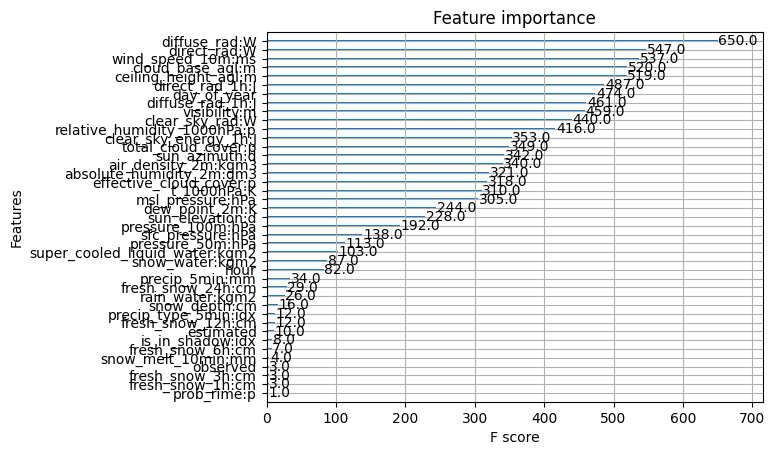

In [22]:
plot_importance(predictor1)

In [11]:
X_2, y_2 = df2_0[[c for c in df2_0.columns if "pv_measurement" != c]], df2_0["pv_measurement"]

In [12]:
study2 = optuna.create_study(direction="minimize")

# Optimize the objective function
print("Optimizing hyperparameters...")
study2.optimize(get_objective(X=X_2,y=y_2 ), n_trials=1)
print("Optimization complete!")
predictor2 = XGBRegressor(**study2.best_params).fit(X_2, y_2)


[I 2023-11-10 18:21:10,292] A new study created in memory with name: no-name-5251dedb-3976-4cc4-af12-48c2d6086afc
/var/folders/y8/9glnt_6110xftbsjpdqd12280000gp/T/ipykernel_70332/4123539858.py:15: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  "subsample": trial.suggest_discrete_uniform("subsample", 0.6, 1.0, 0.05),  # Reduce the range
/var/folders/y8/9glnt_6110xftbsjpdqd12280000gp/T/ipykernel_70332/4123539858.py:16: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.6, 1.0, 0.05),  # Reduce the range


Optimizing hyperparameters...
Training Fold 1...
Fold 1 MAE: 58.370560587021345
Training Fold 2...


[I 2023-11-10 18:21:21,321] Trial 0 finished with value: 58.888319480692175 and parameters: {'tree_method': 'approx', 'max_depth': 9, 'learning_rate': 0.9098928879870335, 'n_estimators': 576, 'min_child_weight': 7, 'gamma': 0.31195507164615166, 'subsample': 0.8, 'colsample_bytree': 0.8, 'reg_alpha': 0.9442315291184267, 'reg_lambda': 0.9467439396259895, 'random_state': 199}. Best is trial 0 with value: 58.888319480692175.


Fold 2 MAE: 59.406078374363
Mean MAE for all Folds: 58.888319480692175
Optimization complete!


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

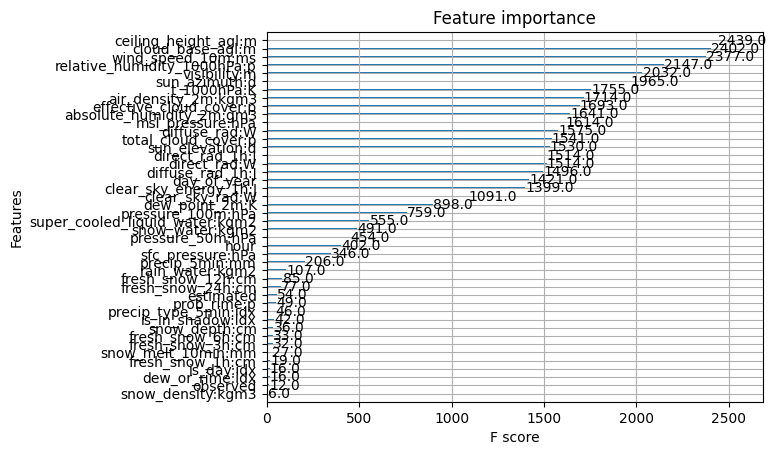

In [23]:
plot_importance(predictor2)

In [13]:
X_3, y_3 = df3_0[[c for c in df3_0.columns if "pv_measurement" != c]], df3_0["pv_measurement"]

In [14]:
study3 = optuna.create_study(direction="minimize")

# Optimize the objective function
print("Optimizing hyperparameters...")
study3.optimize(get_objective(X=X_3,y=y_3 ), n_trials=1)
print("Optimization complete!")
predictor3 = XGBRegressor(**study3.best_params).fit(X_3, y_3)


[I 2023-11-10 18:21:25,208] A new study created in memory with name: no-name-e0f5706e-488f-46e1-a61a-a368eaa4727f
/var/folders/y8/9glnt_6110xftbsjpdqd12280000gp/T/ipykernel_70332/4123539858.py:15: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  "subsample": trial.suggest_discrete_uniform("subsample", 0.6, 1.0, 0.05),  # Reduce the range
/var/folders/y8/9glnt_6110xftbsjpdqd12280000gp/T/ipykernel_70332/4123539858.py:16: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  "colsample_bytree": trial.suggest_discrete_uniform("colsample_bytree", 0.6, 1.0, 0.05),  # Reduce the range


Optimizing hyperparameters...
Training Fold 1...
Fold 1 MAE: 51.24486899461901
Training Fold 2...


[I 2023-11-10 18:21:32,686] Trial 0 finished with value: 51.27239416607777 and parameters: {'tree_method': 'hist', 'max_depth': 8, 'learning_rate': 0.8762946193676969, 'n_estimators': 706, 'min_child_weight': 3, 'gamma': 0.28580241384220484, 'subsample': 0.75, 'colsample_bytree': 0.95, 'reg_alpha': 0.5373289995186017, 'reg_lambda': 0.217555822086801, 'random_state': 869}. Best is trial 0 with value: 51.27239416607777.


Fold 2 MAE: 51.29991933753652
Mean MAE for all Folds: 51.27239416607777
Optimization complete!


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

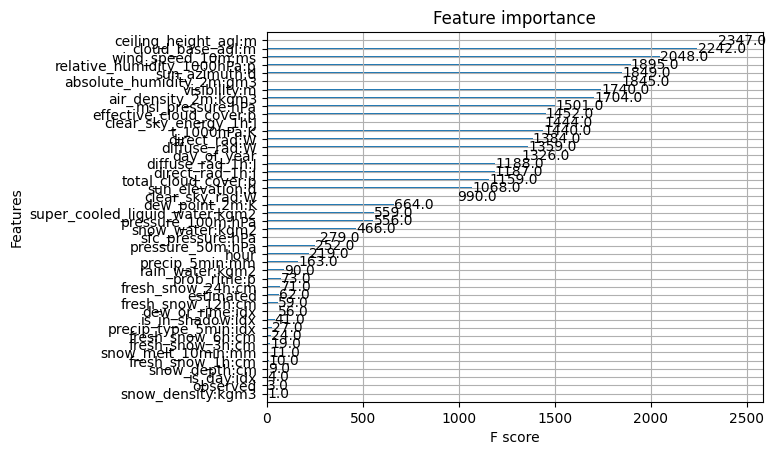

In [24]:
plot_importance(predictor3)

In [15]:
test1 = pipin.get_test_data("A")
test2 = pipin.get_test_data("B")
test3 = pipin.get_test_data("C")

test1 = pipin.drop_columns(test1)
test2 = pipin.drop_columns(test2)
test3 = pipin.drop_columns(test3)

In [16]:
pred1 = pd.DataFrame(predictor1.predict(test1), columns=["pv_measurement"])
pred2 = pd.DataFrame(predictor2.predict(test2), columns=["pv_measurement"])
pred3 = pd.DataFrame(predictor3.predict(test3), columns=["pv_measurement"])
negatives_pred1 = pred1[pred1["pv_measurement"] < 0]
negatives_pred2 = pred2[pred2["pv_measurement"] < 0]
negatives_pred3 = pred3[pred3["pv_measurement"] < 0]
neg = pd.concat([negatives_pred1, negatives_pred2, negatives_pred3])
neg.shape

(364, 1)

In [19]:
study1.bes

array(['absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W',
       'direct_rad_1h:J', 'effective_cloud_cover:p', 'elevation:m',
       'fresh_snow_12h:cm', 'fresh_snow_1h:cm', 'fresh_snow_24h:cm',
       'fresh_snow_3h:cm', 'fresh_snow_6h:cm', 'is_day:idx',
       'is_in_shadow:idx', 'msl_pressure:hPa', 'precip_5min:mm',
       'precip_type_5min:idx', 'pressure_100m:hPa', 'pressure_50m:hPa',
       'prob_rime:p', 'rain_water:kgm2', 'relative_humidity_1000hPa:p',
       'sfc_pressure:hPa', 'snow_density:kgm3', 'snow_depth:cm',
       'snow_drift:idx', 'snow_melt_10min:mm', 'snow_water:kgm2',
       'sun_azimuth:d', 'sun_elevation:d',
       'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'estimated', 'observed', 'day_of

In [17]:
# pred = pd.concat([pred1, pred2, pred3])
# final_prediction = pipin.post_processing(pred, prediction_column="pv_measurement")
# final_prediction.to_csv('submissions/XGB_143_pipeline.csv')